In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from model import Generator, Discriminator
from torchvision.utils import save_image
from tqdm import tqdm
import os
import re
import csv


In [2]:
dataroot = "data/"
save_path = "checkpoints" 

image_save_path = os.path.join(save_path, 'images')
weights_save_path = os.path.join(save_path, 'weights')
loss_save_path = os.path.join(save_path, 'losses.csv')
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(weights_save_path, exist_ok=True) 
image_size = 96  
batch_size = 128
workers = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
dataset = ImageFolder(root=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,drop_last=True)

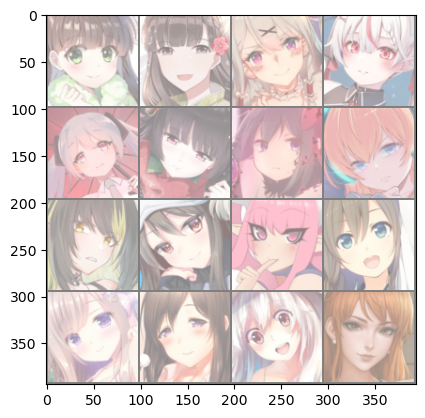

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, _ = next(dataiter)
grid_img = vutils.make_grid(images[:16], nrow=4, padding=2, normalize=True) # 调整nrow值，以适应您的显示
imshow(grid_img)

In [5]:
G = Generator().to(device)
D = Discriminator().to(device)


In [6]:
if not os.path.exists(loss_save_path):
    with open(loss_save_path, mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Epoch', 'Generator Loss', 'Discriminator Loss'])

In [19]:
continue_train = True
start_epoch = 0

if continue_train:
    G_weights_path = 'checkpoints/weights/G_epoch_260.pth'
    D_weights_path = 'checkpoints/weights/D_epoch_260.pth'

    G.load_state_dict(torch.load(G_weights_path))
    D.load_state_dict(torch.load(D_weights_path))

    start_epoch = int(re.findall(r'\d+', os.path.basename(G_weights_path))[0]) + 1



In [9]:
lr = 0.0002
beta1 = 0.5
G_opt = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_opt = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = torch.nn.BCELoss().to(device)
fix_noise = torch.randn(batch_size, 100, 1, 1).to(device)
true_label = torch.ones(batch_size).to(device)
false_label = torch.zeros(batch_size).to(device)
epochs = 301


In [20]:
for epoch in range(start_epoch, epochs):
    
    G_loss_accum = 0.0
    D_loss_accum = 0.0
    num_batches = 0

    for batch_index, (img,_) in enumerate(tqdm(dataloader,total=len(dataloader))):
        noise = torch.randn(batch_size, 100, 1, 1).to(device)
        img = img.to(device)
        # Train Discriminator
        D_opt.zero_grad()

        true = D(img)
        fake_img = G(noise)
        fake = D(fake_img)

        D_loss_t = criterion(true, true_label)
        D_loss_t.backward()

        D_loss_f = criterion(fake, false_label)
        D_loss_f.backward()
        D_opt.step()

        D_loss_accum += D_loss_t.item() + D_loss_f.item()

        # Train Generator
        G_opt.zero_grad()
        fake_img = G(noise)
        fake = D(fake_img)
        G_loss = criterion(fake, true_label)
        G_loss.backward()
        G_opt.step()

        G_loss_accum += G_loss.item()
        num_batches += 1


    if epoch % 5 == 0:
        
        with torch.no_grad():
            fake_img = G(fix_noise).detach().cpu()
        img_grid = vutils.make_grid(fake_img, nrow=8, padding=2, normalize=True)
        vutils.save_image(img_grid, f'{image_save_path}/fake_epoch_{epoch}.jpg')

        torch.save(G.state_dict(), f'{weights_save_path}/G_epoch_{epoch}.pth')
        torch.save(D.state_dict(), f'{weights_save_path}/D_epoch_{epoch}.pth')

    print(f"Epoch {epoch}: G_loss = {G_loss_accum / num_batches:.4f}, D_loss = {D_loss_accum / num_batches:.4f}", end='\r')
    with open(loss_save_path, mode='a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow([epoch, G_loss_accum / num_batches, D_loss_accum / num_batches])




100%|██████████| 416/416 [19:45<00:00,  2.85s/it]


100%|██████████| 416/416 [14:41<00:00,  2.12s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [15:04<00:00,  2.17s/it]


100%|██████████| 416/416 [18:09<00:00,  2.62s/it]


100%|██████████| 416/416 [14:35<00:00,  2.10s/it]


100%|██████████| 416/416 [14:42<00:00,  2.12s/it]


100%|██████████| 416/416 [14:40<00:00,  2.12s/it]


100%|██████████| 416/416 [14:39<00:00,  2.11s/it]


100%|██████████| 416/416 [14:40<00:00,  2.12s/it]


100%|██████████| 416/416 [14:42<00:00,  2.12s/it]


100%|██████████| 416/416 [14:45<00:00,  2.13s/it]


100%|██████████| 416/416 [14:40<00:00,  2.12s/it]


100%|██████████| 416/416 [14:40<00:00,  2.12s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:39<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:40<00:00,  2.12s/it]


100%|██████████| 416/416 [14:39<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:39<00:00,  2.11s/it]


100%|██████████| 416/416 [14:36<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:37<00:00,  2.11s/it]


100%|██████████| 416/416 [14:39<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


100%|██████████| 416/416 [14:38<00:00,  2.11s/it]


In [27]:
G_weights_path = 'checkpoints/weights/G_epoch_230.pth'
#G.eval()
G.load_state_dict(torch.load(G_weights_path))
batch_size = 16
for i in range(10):
    noise = torch.randn(batch_size, 100, 1, 1).to(device)

    with torch.no_grad():
        generated_images = G(noise).detach().cpu()

    image_grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=True)
    vutils.save_image(image_grid, f'generated_image_{i+1}.jpg')




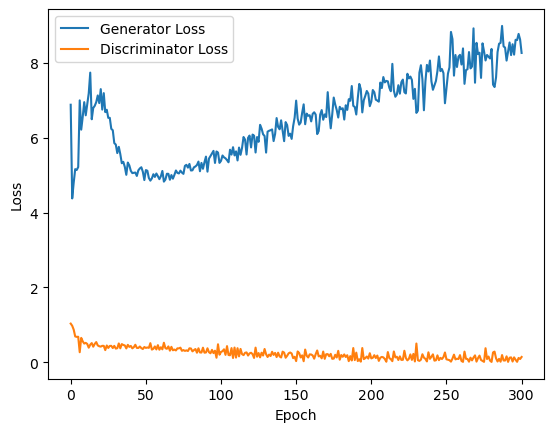

In [21]:
losses_df = pd.read_csv(loss_save_path)

epochs = losses_df['Epoch']
G_losses = losses_df['Generator Loss']
D_losses = losses_df['Discriminator Loss']

plt.plot(epochs, G_losses, label='Generator Loss')
plt.plot(epochs, D_losses, label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()